In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Deep_learning.models import DenseModel

## Dataset

In [122]:
random_samples=pd.read_pickle(filepath_or_buffer="random_samples.pkl")

In [124]:
output = random_samples['Y']
input= random_samples[['morgan_fingerprints', 'Gene_expression']]


## Dataset Split

In [125]:
x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [127]:
x_train_drugs = x_train.filter(regex='morgan', axis=1)
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('morgan_fingerprints') + 1:]

x_val_drugs = x_val.filter(regex='morgan', axis=1)
x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('morgan_fingerprints') + 1:]

x_test_drugs = x_test.filter(regex='morgan', axis=1)
x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('morgan_fingerprints') + 1:]

In [133]:
x_train_drugs = pd.concat([x_train_drugs.drop(['morgan_fingerprints'], axis=1), x_train_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_test_drugs = pd.concat([x_test_drugs.drop(['morgan_fingerprints'], axis=1), x_test_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_val_drugs = pd.concat([x_val_drugs.drop(['morgan_fingerprints'], axis=1), x_val_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)

In [143]:
x_train_drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp2038,fp2039,fp2040,fp2041,fp2042,fp2043,fp2044,fp2045,fp2046,fp2047
61203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28565,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136980,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
x_train_cell = x_train_cell_lines['Gene_expression'].apply(pd.Series)
x_train_cell.columns = [f'gene_{i}' for i in range(x_train_cell.shape[1])]
x_train_cell_lines = pd.concat([x_train_cell_lines.drop(columns=['Gene_expression']), x_train_cell], axis=1)

#####
x_test_cell = x_test_cell_lines['Gene_expression'].apply(pd.Series)
x_test_cell.columns = [f'gene_{i}' for i in range(x_test_cell.shape[1])]
x_test_cell_lines = pd.concat([x_test_cell_lines.drop(columns=['Gene_expression']), x_test_cell], axis=1)

####
x_val_cell = x_val_cell_lines['Gene_expression'].apply(pd.Series)
x_val_cell.columns = [f'gene_{i}' for i in range(x_val_cell.shape[1])]
x_val_cell_lines = pd.concat([x_val_cell_lines.drop(columns=['Gene_expression']), x_val_cell], axis=1)

In [134]:
x_train_cell_lines

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_13339,gene_13340,gene_13341,gene_13342,gene_13343,gene_13344,gene_13345,gene_13346,gene_13347,gene_13348
61203,3.368411,9.614526,4.611837,4.822819,3.616583,3.373405,5.640867,5.694278,5.584741,3.376383,...,4.229357,3.690343,4.283486,2.597072,3.406673,3.462286,9.166342,8.670275,9.417522,7.393711
75671,3.221813,10.225246,4.659468,3.669796,3.609549,3.346536,5.367531,5.876984,5.422398,3.366161,...,4.360444,3.726705,3.999744,2.707081,6.322972,3.413998,8.822016,7.397880,9.718055,7.237709
28565,6.531874,10.770529,4.160171,4.141105,3.310779,3.251689,7.210004,4.706070,5.617586,4.150423,...,3.126415,4.749798,3.402185,2.764914,4.472942,2.974571,8.555600,2.699642,9.406821,6.923154
73655,8.885371,10.355653,5.515540,4.792642,2.993887,3.403733,6.470176,4.741274,5.234000,3.318789,...,3.999652,5.319663,4.782002,2.584468,7.459016,3.086061,8.940100,2.911964,9.297009,7.950319
76365,3.301805,10.706812,4.856403,4.791858,3.206679,3.509558,7.388805,7.109158,7.800635,3.310824,...,4.255869,3.687163,4.623129,2.592868,3.790139,3.222152,8.985425,10.382648,8.932350,7.058897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150073,7.675404,10.363883,3.719575,3.094497,3.141884,3.478029,7.789035,5.117950,4.202900,3.649163,...,3.551884,4.074145,3.311678,2.559860,4.021473,2.993180,7.787336,3.328702,9.443993,9.070178
111995,9.354246,10.867766,3.923570,3.158144,3.433552,4.046115,6.855342,9.250892,4.222959,3.888445,...,3.911408,4.198074,3.349738,2.668601,5.773753,3.427834,7.696469,3.504819,9.974507,7.827104
93322,6.355386,10.800610,4.494676,3.750520,3.223805,3.179793,3.311374,10.351264,4.074604,3.701643,...,3.397122,3.670862,3.463549,2.576121,5.135950,3.135136,7.840230,3.266005,9.535042,7.745727
136980,7.646494,10.153853,3.564755,3.942749,3.290760,3.551675,8.252413,5.831479,4.716446,3.834392,...,3.901020,4.152362,3.671645,2.483813,4.800394,3.031739,7.850447,3.123141,9.170450,6.911407


In [129]:
x_train_drugs.shape, x_train_cell_lines.shape, y_train.shape

((3000, 1), (3000, 13349), (3000,))

In [130]:
x_test_drugs.shape, x_test_cell_lines.shape, y_test.shape

((1000, 1), (1000, 13349), (1000,))

In [131]:
x_val_drugs.shape, x_val_cell_lines.shape, y_val.shape

((1000, 1), (1000, 13349), (1000,))

In [135]:
y_train

61203     0.517675
75671     2.024660
28565     3.848672
73655     4.161746
76365     3.982742
            ...   
150073   -0.802298
111995    0.426848
93322    -1.705260
136980   -2.057754
32449     2.304663
Name: Y, Length: 3000, dtype: float64

## Dense Model

In [136]:
model = DenseModel(x_train_cell_lines.values.shape[1], x_train_drugs.values.shape[1],expr_hlayers_sizes='[625, 312]', drug_hlayers_sizes='[1000, 500, 250]',predictor_hlayers_sizes='[1000]', hidden_dropout=0.3, optimizer='Adam', learning_rate=0.0001)
print(model.summary())

model.train(x_train_cell_lines.values, x_train_drugs.values, y_train.values, epochs=100, batch_size=126)

val_loss, val_mae = model.evaluate(x_val_cell_lines.values, x_val_drugs.values, y_val.values)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines.values, x_test_drugs.values)
print(predictions)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cell_line_input     │ (None, 13349)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drug_input          │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10)        │    133,500 │ cell_line_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 10)        │     20,490 │ drug_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 10)        │          0 │ dense_18[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 10)        │          0 │ dense_19[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ activation_18[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ activation_19[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_concat  │ (None, 20)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1000)      │     21,000 │ input_layer_conc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 1000)      │          0 │ dense_20[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000)      │      4,000 │ activation_20[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1000)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ic50_prediction_de… │ (None, 1)         │      1,001 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 180,071 (703.40 KB)

 Trainable params: 178,031 (695.43 KB)

 Non-trainable params: 2,040 (7.97 KB)

None
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 14.1129 - mae: 3.1305 - val_loss: 8.4168 - val_mae: 2.4145
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.7652 - mae: 2.8754 - val_loss: 9.5068 - val_mae: 2.6256
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.1998 - mae: 2.6701 - val_loss: 10.0488 - val_mae: 2.7180
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3274 - mae: 2.5616 - val_loss: 8.3713 - val_mae: 2.4010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7840 - mae: 2.4704 - val_loss: 6.9272 - val_mae: 2.0528
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3664 - mae: 2.3972 - val_loss: 7.2144 - val_mae: 2.1856
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6036 - mae: 2.2936 - val_loss: 7.3415 - val_mae: 2.2153
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4930 - mae: 2.1018 - val_loss: 6.9196 - val_mae: 2.1311
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l

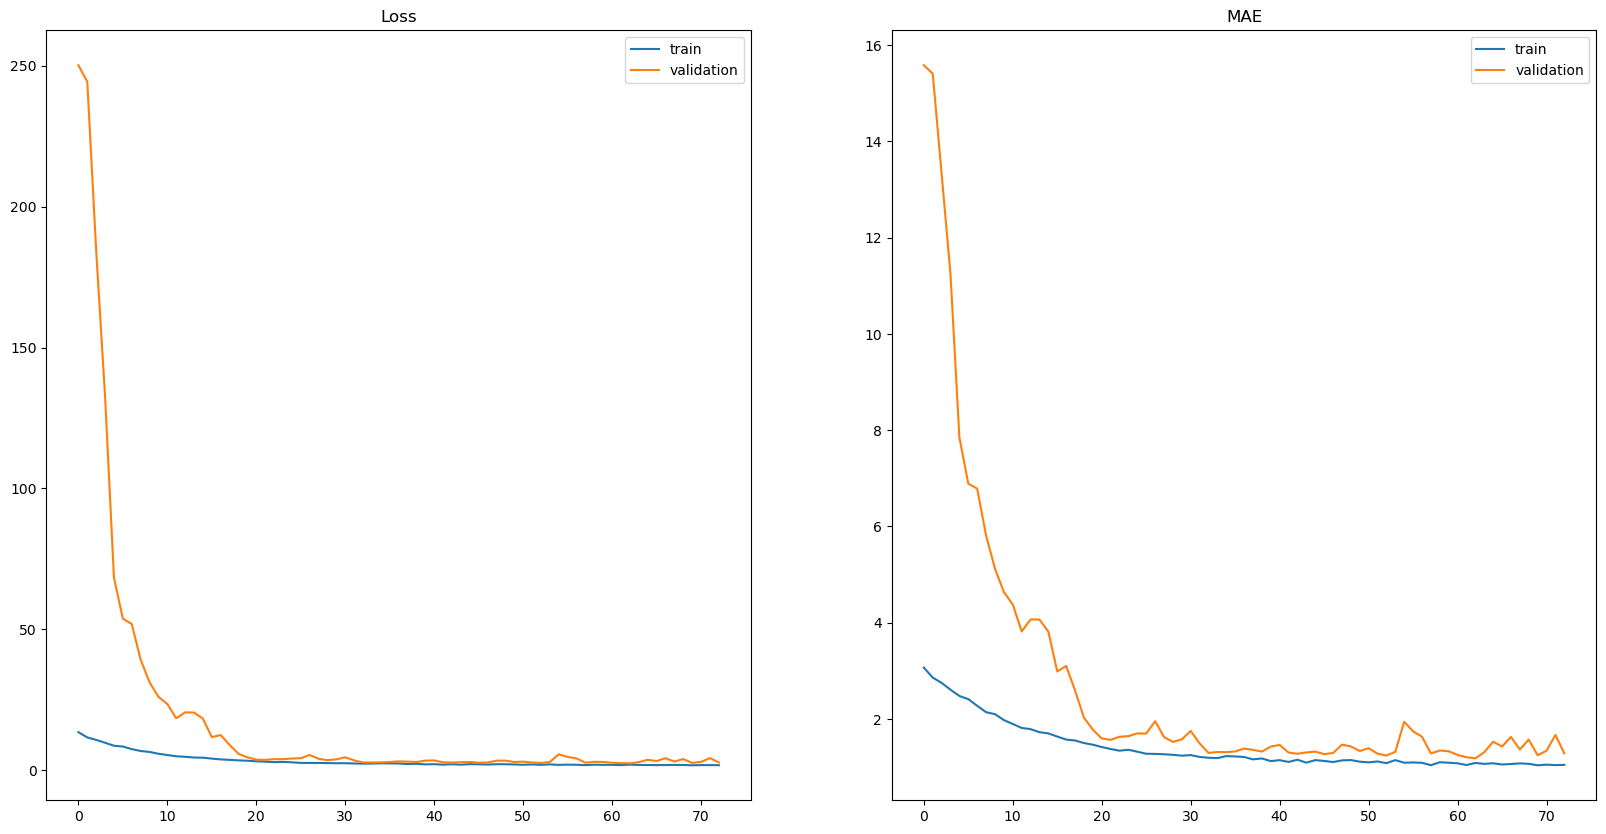

In [112]:
#plot loss and mae from training and validation data side by side

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print('Dense model')
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2: ', r2_score(y_test, predictions))

Dense model
MAE:  1.227531943015616
MSE:  2.614068765896339
RMSE:  1.616808203188102
R2:  0.682557370843193


## Gat Model